In [1]:
# System
import os
import math as m

# Data import and conversion
import numpy as np
import pandas as pd
import datetime as dt

# Results presentation
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
SAVE_INFO = True

In [3]:
if (SAVE_INFO == True):
    DATA_DIR = 'Data/'
    EXPERIMENT_DIR = DATA_DIR + 'Experiment_unet_after_some_time_4/'
    os.makedirs(EXPERIMENT_DIR)

### посмотрим что мы имеем

In [4]:
data = pd.read_csv('earthquakes_data.csv', sep=',')
data

,year,month,date,hour,minute,seconds,lat,long,depth,class
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4


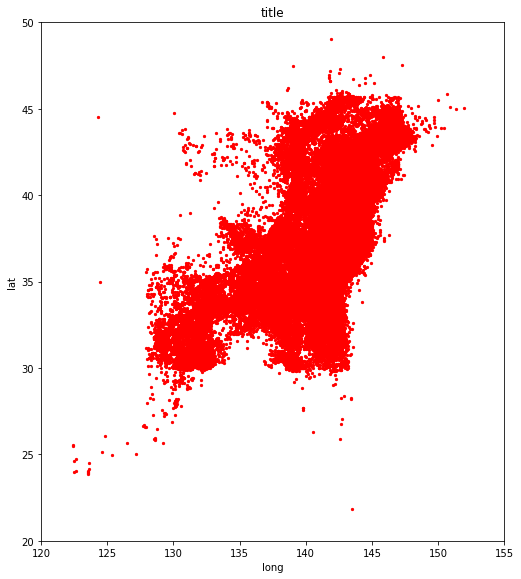

In [5]:
fig = plt.figure(figsize=(10.5 * m.cos(40 * m.pi / 180), 9))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['long'], data['lat'], color='red', marker='.', s=20)
plt.axis([120.0, 155.0, 20.0, 50.0])

axes.set_xlabel('long')
axes.set_ylabel('lat')
axes.set_title('title')

plt.show()

### Спроецируем Японию на плоскость

In [6]:
R_polus   = 6356.86
R_ekvator = 6378.20

def local_radius (longitude):
    return m.cos (longitude * m.pi / 180) * (R_ekvator - R_polus) + R_polus

R_japan = local_radius (37)

In [7]:
ORIGIN_LATITUDE  = 28.8
ORIGIN_LONGITUDE = 127.0

def spherical_to_cartesian (longitude, latitude):
    X = ((longitude - ORIGIN_LONGITUDE)
        * m.pi
        / 180
        * R_japan
        * m.cos (latitude * m.pi / 180))
    Y = ((latitude  - ORIGIN_LATITUDE )
        * m.pi
        / 180
        * R_japan )
    
    return X, Y

data.shape

(247474, 10)

In [8]:
XY_massive = np.zeros((data.shape[0], 2))
j = 0
for i in tqdm(range (XY_massive.shape[0])):
    XY_massive[i][0], XY_massive[i][1] = spherical_to_cartesian (data['long'][i], data['lat'][i])

data['x'] = XY_massive[:, 0]
data['y'] = XY_massive[:, 1]
#data['lat'], data['long'] = spherical_to_cartesian (data['lat'], data['long'])

A Jupyter Widget

#### Посмотрим что получилось

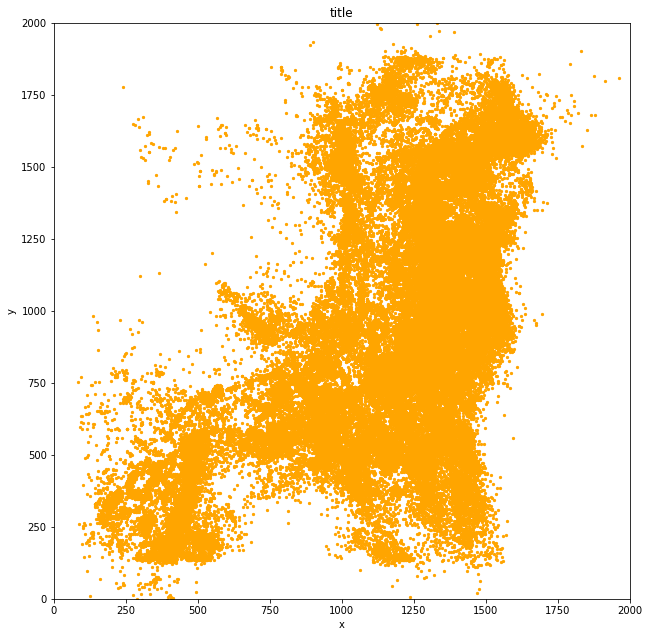

In [9]:
fig = plt.figure(figsize=(10, 10))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
plt.axis([0, 2000, 0, 2000])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('title')

if (SAVE_INFO == True):
    plt.savefig(EXPERIMENT_DIR + 'map.png', format='png', dpi=100)
plt.show()

In [10]:
a = np.zeros(20, dtype=int)
for i in tqdm(range (data.shape[0])):
    for threshold in range (20):
        if (data['class'][i] >= threshold/2) and (data['class'][i] < threshold/2 + 0.5):
            a[threshold] += 1
            break

            
# print ((a / data.shape[0] * 100).int())

    

A Jupyter Widget

#### Распечатаем сколько землетрясений и с какой амплитудой случалось

In [11]:
if (SAVE_INFO == True):
    distr_file = open (EXPERIMENT_DIR + 'earthquakes_distribution.txt', 'w')

for i in range (a.shape[0]):
    print ('from ', i/2, ' to ', i/2+0.5, ' : %.2f' % (a[i]/data.shape[0]*100), '% of dots')
    if (SAVE_INFO == True):
        print ('from ', i/2, ' to ', i/2+0.5, ' : %.2f' % (a[i]/data.shape[0]*100), '% of dots', file=distr_file)
        
if (SAVE_INFO == True):
    distr_file.close()


from  0.0  to  0.5  : 0.00 % of dots
from  0.5  to  1.0  : 0.00 % of dots
from  1.0  to  1.5  : 0.00 % of dots
from  1.5  to  2.0  : 0.00 % of dots
from  2.0  to  2.5  : 0.00 % of dots
from  2.5  to  3.0  : 51.02 % of dots
from  3.0  to  3.5  : 29.93 % of dots
from  3.5  to  4.0  : 11.94 % of dots
from  4.0  to  4.5  : 4.49 % of dots
from  4.5  to  5.0  : 1.65 % of dots
from  5.0  to  5.5  : 0.59 % of dots
from  5.5  to  6.0  : 0.23 % of dots
from  6.0  to  6.5  : 0.09 % of dots
from  6.5  to  7.0  : 0.03 % of dots
from  7.0  to  7.5  : 0.01 % of dots
from  7.5  to  8.0  : 0.00 % of dots
from  8.0  to  8.5  : 0.00 % of dots
from  8.5  to  9.0  : 0.00 % of dots
from  9.0  to  9.5  : 0.00 % of dots
from  9.5  to  10.0  : 0.00 % of dots


#### Посчитаем сколько дней прошло с 01.01.1990 до i-го землетрясения

In [12]:
time_massive = np.zeros (data.shape[0])

d_0 = dt.date (data['year'][0], data['month'][0], data['date'][0])
for i in tqdm(range (data.shape[0])):
    d_i = dt.date (data['year'][i], data['month'][i], data['date'][i])
    time_massive[i] = (d_i - d_0).days
    
data['time'] = time_massive

A Jupyter Widget

#### Посмотрим что имеем 

In [13]:
data

,year,month,date,hour,minute,seconds,lat,long,depth,class,x,y,time
0,1990,1,1,2,19,5.018,42.2734,144.8460,8.0,2.9,1469.001496,1498.856352,0.0
1,1990,1,1,4,4,20.026,39.9358,142.5461,30.6,3.0,1326.068924,1238.808658,0.0
2,1990,1,1,7,14,11.038,36.7053,141.2990,18.6,2.7,1275.297146,879.429774,0.0
3,1990,1,1,9,3,12.039,36.4859,140.6964,67.2,4.3,1225.030854,855.022492,0.0
4,1990,1,1,12,31,25.018,35.0121,138.1440,22.6,2.5,1015.369695,691.068739,0.0
5,1990,1,1,18,2,34.067,35.1802,136.5092,11.0,2.5,864.632781,709.769123,0.0
6,1990,1,1,23,52,50.070,39.8000,143.7200,0.0,3.0,1429.027552,1223.701506,0.0
7,1990,1,2,6,53,12.093,35.5828,141.2393,24.7,2.9,1288.276622,754.556598,1.0
8,1990,1,2,9,43,46.029,42.2963,142.3826,25.1,3.0,1265.765445,1501.403876,1.0
9,1990,1,2,10,4,50.086,39.6835,142.9171,34.0,3.4,1362.707004,1210.741395,1.0


## Разбиение датасета по дням и по клетка в сетке

In [14]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2000

N_CELLS_HOR = 224
N_CELLS_VER = 224

print (data['time'][data.shape[0] - 1])
celled_data = torch.zeros ([int (data['time'][data.shape[0] - 1] + 1), 1, N_CELLS_HOR, N_CELLS_VER])
print (celled_data.shape)

for i in tqdm(range (data.shape[0])):
    if (data['x'][i] > LEFT_BORDER) and (data['x'][i] < RIGHT_BORDER) and (data['y'][i] > DOWN_BORDER) and (data['y'][i] < UP_BORDER):
        x = int (data['x'][i] / (RIGHT_BORDER - LEFT_BORDER) * N_CELLS_HOR)
        y = int (data['y'][i] / (UP_BORDER    - DOWN_BORDER) * N_CELLS_VER)
        celled_data[int(data['time'][i]), 0, x, y] = data['class'][i]
#         celled_data[int(data['time'][i]), 1, x, y] = data['depth'][i]
        
# celled_data
del data
        
    


9590.0
torch.Size([9591, 1, 224, 224])


A Jupyter Widget

In [15]:
print (celled_data.shape)
print (celled_data.dtype)

torch.Size([9591, 1, 224, 224])
torch.float32


# Обучение

In [16]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
print (DEVICE)
torch.cuda.set_device(DEVICE_ID)

cuda:0


In [17]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

### Создадим датасет
#### (Может не влезть в оперативку (надо ~ 12Gb))

In [18]:
OBSERVED_DAYS = 32     # 1 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
STEP = 10
TESTING_DAYS = 500

In [19]:
# range (celled_data.shape[0] - DAYS_TO_PREDICT - TESTING_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT, STEP)
# range (OBSERVED_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT - TESTING_DAYS, STEP)

class EartquakeDataset_MSE (Dataset):     # MSELoss
    def __init__(self, celled_data, indicies):
        
        self.data   = torch.zeros ([0, OBSERVED_DAYS, N_CELLS_HOR, N_CELLS_VER])
        self.result = torch.zeros ([0,             1, N_CELLS_HOR, N_CELLS_VER])
        for i in tqdm(indicies):
            current_history = celled_data[(i - OBSERVED_DAYS):(i), :, :, :].squeeze(1)
            current_history = current_history.unsqueeze(0)
            self.data   = torch.cat((self.data, current_history), dim=0)

            self.result = torch.cat ((self.result, torch.sum (celled_data[(i + DAYS_TO_PREDICT_AFTER):(i + DAYS_TO_PREDICT_BEFORE), :, :, :], dim=0, keepdim=True)), dim=0)
      
        print ('data_shape   = ', self.data.shape)
        print ('result_shape = ', self.result.shape)
        
        
        
        assert (self.data.shape[0] == self.result.shape[0])
        self.size = self.data.shape[0]
        
    def __len__ (self):
        return self.size
    
    def __getitem__(self, idx):
#         print ('data_shape = ', self.data[idx].shape)
#         print ('result_shape = ', self.result[idx].shape)
        return self.data[idx], self.result[idx]


In [20]:
HEAVY_QUAKE_THRES = 3.5

class EartquakeDataset_CE (Dataset):      #crossEntropyLoss
    def __init__(self, celled_data, indicies):
        
        self.data   = torch.FloatTensor (0, OBSERVED_DAYS, N_CELLS_HOR, N_CELLS_VER)
        self.result = torch.ByteTensor  (0,             1, N_CELLS_HOR, N_CELLS_VER)
        for i in tqdm(indicies):
            cur_history = celled_data[(i - OBSERVED_DAYS):(i), :, :, :].squeeze(1)
            cur_history = cur_history.unsqueeze(0)
            self.data   = torch.cat((self.data, cur_history), dim=0)
            
            cur_results = torch.sum ((celled_data[(i + DAYS_TO_PREDICT_AFTER):(i + DAYS_TO_PREDICT_BEFORE), :, :, :]>HEAVY_QUAKE_THRES), dim=0, keepdim=True)>0
            self.result = torch.cat ((self.result, cur_results), dim=0)
        
        print ('data_shape   = ', self.data.shape)
        print ('result_shape = ', self.result.shape)
        
        assert (self.data.shape[0] == self.result.shape[0])
        self.size = self.data.shape[0]
        
    def __len__ (self):
        return self.size
    
    def __getitem__(self, idx):
#         print ('data_shape = ', self.data[idx].shape)
#         print ('result_shape = ', self.result[idx].shape)
        return self.data[idx], self.result[idx]


In [21]:
earthquakes_dataset_train = EartquakeDataset_CE (celled_data,
                                                 range (OBSERVED_DAYS, 
                                                        
                                                        celled_data.shape[0] 
                                                        - DAYS_TO_PREDICT_BEFORE - 
                                                        TESTING_DAYS,
                                                        
                                                        STEP)
                                                 )
earthquakes_dataset_test  = EartquakeDataset_CE (celled_data,
                                                 range (celled_data.shape[0]
                                                        - DAYS_TO_PREDICT_BEFORE
                                                        - TESTING_DAYS,
                                                        
                                                        celled_data.shape[0]
                                                        - DAYS_TO_PREDICT_BEFORE,
                                                        
                                                        STEP)
                                                 )

A Jupyter Widget


data_shape   =  torch.Size([901, 32, 224, 224])
result_shape =  torch.Size([901, 1, 224, 224])


A Jupyter Widget


data_shape   =  torch.Size([50, 32, 224, 224])
result_shape =  torch.Size([50, 1, 224, 224])


In [22]:
# earthquakes_dataset_train = EartquakeDataset_MSE (celled_data,
#                                                  range (OBSERVED_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT - TESTING_DAYS, STEP)
#                                                  )

# earthquakes_dataset_test  = EartquakeDataset_MSE (celled_data,
#                                                  range (celled_data.shape[0] - DAYS_TO_PREDICT - TESTING_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT, STEP)
#                                                  )

In [23]:
print (earthquakes_dataset_train.data.shape)
print (earthquakes_dataset_test .result.shape)

print (earthquakes_dataset_train.data.dtype)
print (earthquakes_dataset_test .result.dtype)

torch.Size([901, 32, 224, 224])
torch.Size([50, 1, 224, 224])
torch.float32
torch.uint8


In [24]:
earthquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=4)

earthquakes_dataloader_test  = DataLoader(earthquakes_dataset_test,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=1)

### Создадим саму сеть

In [25]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
        self.RELU  = nn.ReLU ()
        
        self.MAXPOOL = nn.MaxPool2d(3,
                                    stride=1,
                                    padding=1,
                                    dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
        x = self.RELU   (x)
        x = self.MAXPOOL(x)
        
        return x

In [26]:
class ConvNetwork_CE (nn.Module):
    
    def __init__(self):
        super(ConvNetwork_CE, self).__init__()
        
        self.features = nn.Sequential()
        
        self.features.add_module('conv1', ConvBlock(OBSERVED_DAYS, 32, 3))
        self.features.add_module('conv2', ConvBlock(           32, 16, 3))
        self.features.add_module('conv3', ConvBlock(           16,  8, 3))
        self.features.add_module('conv4', ConvBlock(            8,  4, 3))
        self.features.add_module('conv5', ConvBlock(            4,  2, 3))
        
#         N_CELLS_HOR = 200
#         N_CELLS_VER = 250
        # might be a good idea to add an extra full connected layer
        # max pooling попробовать - между конволюциями
        # в конце фулл конектед
        self.FC1     = nn.Linear  (2, 2)
        self.glob_relu = nn.ReLU  ()
        self.FC2     = nn.Linear  (2, 2)
        
        self.SOFTMAX = nn.Softmax (dim=1);
        
    def forward(self, x):
#         print ('input  : ', x.shape)
        x = self.features(x)
        x = x.transpose (dim0=1, dim1=3)
        x = self.FC1  (x)
        x = self.glob_relu (x)
        x = self.FC2  (x)
        x = x.transpose (dim0=1, dim1=3)
        x = self.SOFTMAX (x)
#         print ('output : ', x.shape)
        return x
        

### Let's take a model from a classical segmentation problem
![Unet](./img/Unet.png)

In [27]:
class DoubleConv(nn.Module):
    def __init__ (self, in_size, out_size):
        super(DoubleConv, self).__init__()

        self.conv1 = nn.Conv2d (in_size , out_size, 3, padding=1)
        self.bn1   = nn.BatchNorm2d (out_size)
        self.Relu  = nn.ReLU ()
        self.conv2 = nn.Conv2d (out_size, out_size, 3, padding=1)
        self.bn2   = nn.BatchNorm2d (out_size)
        
    def forward (self, x):
        x = self.conv1(x)
        x = self.bn1  (x)
        x = self.Relu (x)
        x = self.conv2(x)
        x = self.bn2  (x)
        x = self.Relu (x)
        return x


In [28]:
class UnetNetwork (nn.Module):
    
    def __init__(self, in_channels=OBSERVED_DAYS):
        super(UnetNetwork, self).__init__()
    
        self.down1    = DoubleConv   (in_channels, 64)
        self.maxpool2 = nn.MaxPool2d (2, stride=2)  # 224 in 112
        self.down2    = DoubleConv   (64, 128)
        self.maxpool3 = nn.MaxPool2d (2, stride=2)  # 112 in 56
        self.down3    = DoubleConv   (128, 256)
        self.maxpool4 = nn.MaxPool2d (2, stride=2)  # 56  in 28
        self.down4    = DoubleConv   (256, 512)
        self.maxpool5 = nn.MaxPool2d (2, stride=2)  # 28  in 14
        self.down5    = DoubleConv   (512, 1024)
        
        self.upConv1  = nn.ConvTranspose2d (1024, 512, 2, stride=2)
        self.up1      = DoubleConv (1024, 512)
        self.upConv2  = nn.ConvTranspose2d (512, 256, 2, stride=2)
        self.up2      = DoubleConv (512 , 256)
        self.upConv3  = nn.ConvTranspose2d (256, 128, 2, stride=2)
        self.up3      = DoubleConv (256 , 128)
        self.upConv4  = nn.ConvTranspose2d (128, 64, 2, stride=2)
        self.up4      = DoubleConv (128 , 64 )
        
        self.lastConv = nn.Conv2d (64, 2, 1)
        self.SOFTMAX  = nn.Softmax (dim=1);
        
        
    def forward (self, input):
        
        x1 = self.down1 (input)
        x2 = self.down2 (self.maxpool2 (x1))
        x3 = self.down3 (self.maxpool3 (x2))
        x4 = self.down4 (self.maxpool4 (x3))
        
        x  = self.down5 (self.maxpool5 (x4))
        
        x  = self.up1 (torch.cat ((x4, self.upConv1(x)), dim=1))
        x  = self.up2 (torch.cat ((x3, self.upConv2(x)), dim=1))
        x  = self.up3 (torch.cat ((x2, self.upConv3(x)), dim=1))
        x  = self.up4 (torch.cat ((x1, self.upConv4(x)), dim=1))
        
        x  = self.SOFTMAX(self.lastConv(x))
        
        return x
        
        
        
        
        

#### Функция тренеровки

In [29]:
def train_network_CE (network, 
                      device,
                      dataloader_train,
                      dataloader_test,
                      epochs=200,
                      learning_rate=0.1,
                      earthquake_weight=1.):
    
    if (SAVE_INFO == True):
        epochs_file = open (EXPERIMENT_DIR + 'Epochs_info.txt', 'w')
    
    loss_acc  = []
    test_acc  = []
    test_prec = []
    test_rec  = []
    net = network.to(device)

    weights = torch.tensor([1., earthquake_weight], dtype = torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weights)
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        if epoch == epochs/2:
            optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9)
            print ('Changed learning rate to ', learning_rate/10)
        elif epoch == epochs*3/4:
            optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
            print ('Changed learning rate to ', learning_rate/100)
            
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_elems = 0
        for data in dataloader_train:
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
#             print ('inputs_shape = ', inputs.shape)
#             print ('labels_shape = ', labels.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
#             print ('outputs : ', outputs.shape, outputs.dtype)
#             print ('labels  : ', labels.shape , labels.dtype)
#             outputs = torch.cat ((1-outputs, outputs), dim=1)
#             print ('outputs ', outputs.shape, '   [', outputs[1, 0, 12, 12], outputs[1, 1, 12, 12], ']')
            loss = criterion(outputs, labels.squeeze(1).long())
            loss.backward()
            optimizer.step()

#             print (loss)
            epoch_elems    += labels.shape[0]
            epoch_accuracy += loss.item()*labels.shape[0]

        epoch_accuracy /= epoch_elems
        loss_acc.append(epoch_accuracy)
        
        
#         calculating test accuracy, precision and recall
        epoch_accuracy  = 0.0
        epoch_precision = 0.0
        epoch_recall    = 0.0
        epoch_elems = 0
        for data in dataloader_test:
            inputs = data[0].to(device)
            labels = data[1].to(device)   
            outputs = net(inputs)
#             find_mistake(outputs)
            accuracy = my_accuracy (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
            precision, recall = my_precision_recall (outputs[:, 1, :, :].unsqueeze(1), labels, 0.5)
#             accuracy2 = my_accuracy (outputs, labels, 1.0)
            
            epoch_elems     += labels.shape[0]
            epoch_accuracy  += accuracy.item()  * labels.shape[0]
            epoch_precision += precision.item() * labels.shape[0]
            epoch_recall    += recall.item()    * labels.shape[0]

#         epoch_accuracy /= epoch_elems
        test_acc .append (epoch_accuracy  / epoch_elems)
        test_prec.append (epoch_precision / epoch_elems)
        test_rec .append (epoch_recall    / epoch_elems)
        
        
        print('Ep :', epoch,
              'loss_tr :' , round (loss_acc [-1], 7),
              'acc_ts :'  , round (test_acc [-1], 4),
              'prec_ts :' , round (test_prec[-1], 4),
              'rec_ts :'  , round (test_rec [-1], 4))
        
        if (SAVE_INFO == True):
            print('Ep :', epoch,
                  'loss_tr :' , round (loss_acc [-1], 7),
                  'acc_ts :'  , round (test_acc [-1], 4),
                  'prec_ts :' , round (test_prec[-1], 4),
                  'rec_ts :'  , round (test_rec [-1], 4)
                  , file=epochs_file)


    print('Finished Training')
    
#     plt.plot(train_acc, label='Train')
    plt.plot(loss_acc , label='Loss')
    plt.legend()
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Loss_train.png', format='png', dpi=100)
    plt.show()
    
    plt.plot(test_acc , label='Test Accuracy')
    plt.legend()
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Accuracy_test.png', format='png', dpi=100)
    plt.show()
    
    plt.plot(test_prec, label='Test Precision')
    plt.legend()
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_test.png', format='png', dpi=100)
    plt.show()
    
    plt.plot(test_rec , label='Test Recall')
    plt.legend()
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_test.png', format='png', dpi=100)
    plt.show()
    
    if (SAVE_INFO == True):
        epochs_file.close()

A Jupyter Widget

Ep : 0 loss_tr : 0.4298239 acc_ts : 0.7699 prec_ts : 0.0042 rec_ts : 0.9421
Ep : 1 loss_tr : 0.4033184 acc_ts : 0.7474 prec_ts : 0.0038 rec_ts : 0.9419
Ep : 2 loss_tr : 0.4001141 acc_ts : 0.767 prec_ts : 0.0043 rec_ts : 0.9412
Ep : 3 loss_tr : 0.394713 acc_ts : 0.7975 prec_ts : 0.0049 rec_ts : 0.9336
Ep : 4 loss_tr : 0.3907049 acc_ts : 0.7843 prec_ts : 0.0046 rec_ts : 0.9463
Ep : 5 loss_tr : 0.3858681 acc_ts : 0.7711 prec_ts : 0.0043 rec_ts : 0.9309
Ep : 6 loss_tr : 0.3845625 acc_ts : 0.8028 prec_ts : 0.005 rec_ts : 0.9286
Ep : 7 loss_tr : 0.3805758 acc_ts : 0.8061 prec_ts : 0.0051 rec_ts : 0.9141
Ep : 8 loss_tr : 0.3785015 acc_ts : 0.808 prec_ts : 0.0052 rec_ts : 0.9195
Ep : 9 loss_tr : 0.3757892 acc_ts : 0.8166 prec_ts : 0.0054 rec_ts : 0.9278
Ep : 10 loss_tr : 0.3735994 acc_ts : 0.8257 prec_ts : 0.0056 rec_ts : 0.9065
Ep : 11 loss_tr : 0.371314 acc_ts : 0.8309 prec_ts : 0.0058 rec_ts : 0.9161
Ep : 12 loss_tr : 0.3703017 acc_ts : 0.8318 prec_ts : 0.0059 rec_ts : 0.9126
Ep : 13 loss_t

Ep : 107 loss_tr : 0.3281329 acc_ts : 0.9279 prec_ts : 0.0155 rec_ts : 0.5955
Ep : 108 loss_tr : 0.3277868 acc_ts : 0.9286 prec_ts : 0.0158 rec_ts : 0.5856
Ep : 109 loss_tr : 0.3275465 acc_ts : 0.9289 prec_ts : 0.0158 rec_ts : 0.5861
Ep : 110 loss_tr : 0.3273936 acc_ts : 0.9292 prec_ts : 0.0162 rec_ts : 0.5743
Ep : 111 loss_tr : 0.3272509 acc_ts : 0.9301 prec_ts : 0.0165 rec_ts : 0.5732
Ep : 112 loss_tr : 0.3270182 acc_ts : 0.9302 prec_ts : 0.0167 rec_ts : 0.5682
Ep : 113 loss_tr : 0.3270366 acc_ts : 0.9309 prec_ts : 0.0167 rec_ts : 0.5672
Ep : 114 loss_tr : 0.3269286 acc_ts : 0.9305 prec_ts : 0.0167 rec_ts : 0.5617
Ep : 115 loss_tr : 0.3266122 acc_ts : 0.9318 prec_ts : 0.017 rec_ts : 0.5621
Ep : 116 loss_tr : 0.3266278 acc_ts : 0.932 prec_ts : 0.0173 rec_ts : 0.5513
Ep : 117 loss_tr : 0.3263581 acc_ts : 0.9314 prec_ts : 0.0172 rec_ts : 0.5409
Ep : 118 loss_tr : 0.3263199 acc_ts : 0.9325 prec_ts : 0.0175 rec_ts : 0.5545
Ep : 119 loss_tr : 0.3262062 acc_ts : 0.9321 prec_ts : 0.0174 rec_

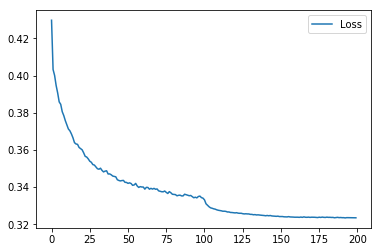

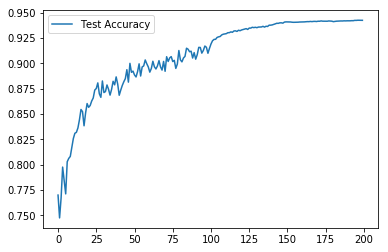

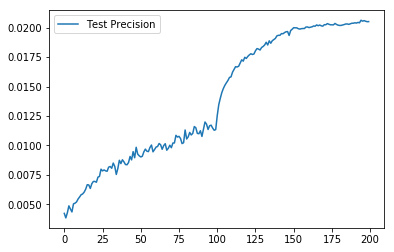

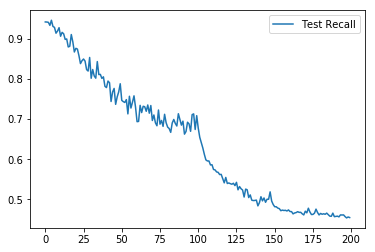

In [30]:
LEARNING_RATE = 0.1
N_EPOCHS = 200
EARTHQUAKE_WEIGHT = 2000.

# earthquake_network = ConvNetwork_CE ()
earthquake_network = UnetNetwork ()
train_network_CE  (earthquake_network,
                   torch.device(DEVICE),
                   earthquakes_dataloader_train,
                   earthquakes_dataloader_test,
                   epochs=N_EPOCHS,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT
                   )

In [31]:
def print_ROC_info (model, dataLoader, device, alpha=0.5, n_dots=5001):
    model = model.to(device)
    
    
    threshold_massive = np.linspace (0, n_dots-1, n_dots, dtype=int)
    TP_massive = np.zeros (n_dots)
    FP_massive = np.zeros (n_dots)
    FN_massive = np.zeros (n_dots)
    TN_massive = np.zeros (n_dots)
    
    for data in dataLoader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        
        for threshold in threshold_massive:
            prediction = (outputs[:, 1, :, :].unsqueeze(1)) > (threshold/n_dots)
            TP_massive[threshold] += torch.sum (prediction       * labels      ).float()
            FP_massive[threshold] += torch.sum (prediction       * (1 - labels)).float()
            FN_massive[threshold] += torch.sum ((1 - prediction) * labels      ).float()
            TN_massive[threshold] += torch.sum ((1 - prediction) * (1 - labels)).float()
            
    threshold_massive = threshold_massive / (n_dots-1)
    precision_massive = TP_massive / (TP_massive + FP_massive)
    TPR_massive       = TP_massive / (TP_massive + FN_massive)
    FPR_massive       = FP_massive / (FP_massive + TN_massive)

    sum_events = TP_massive[int(len(TP_massive)/2)] + FP_massive[int(len(FP_massive)/2)] + FN_massive[int(len(FN_massive)/2)] + TN_massive[int(len(TN_massive)/2)] 
    print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%')
    print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%')
    print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%')
    print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%')
    
    if (SAVE_INFO == True):
        print ('TP = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('FP = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('FN = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('TN = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
    
    # plot 1 precision
    fig1 = plt.figure(figsize=(10, 6))

    axes = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(threshold_massive, precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(threshold_massive, TPR_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, TPR_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve.png', format='png', dpi=100)
    plt.show()
    
    del model
    del inputs
    del labels

In [32]:
def print_ROC_info2 (model, dataLoader, device, alpha=0.5, n_dots=5001):
    model = model.to(device)
    
    
    threshold_massive = np.linspace (0, n_dots-1, n_dots, dtype=int)
    TP_massive = np.zeros (n_dots)
    FP_massive = np.zeros (n_dots)
    FN_massive = np.zeros (n_dots)
    TN_massive = np.zeros (n_dots)
    
    for data in dataLoader:
        inputs = data[0].to(device)
        labels = data[1].to(device)

        outputs = model(inputs)
        
        for threshold in threshold_massive:
            prediction = (outputs[:, 1, :, :].unsqueeze(1)) > (threshold/n_dots)
            TP_massive[threshold] += torch.sum (prediction       * labels      ).float()
            FP_massive[threshold] += torch.sum (prediction       * (1 - labels)).float()
            FN_massive[threshold] += torch.sum ((1 - prediction) * labels      ).float()
            TN_massive[threshold] += torch.sum ((1 - prediction) * (1 - labels)).float()
            
    threshold_massive = threshold_massive / (n_dots-1)
    precision_massive = TP_massive / (TP_massive + FP_massive)
    TPR_massive       = TP_massive / (TP_massive + FN_massive)
    FPR_massive       = FP_massive / (FP_massive + TN_massive)

    sum_events = TP_massive[int(len(TP_massive)/2)] + FP_massive[int(len(FP_massive)/2)] + FN_massive[int(len(FN_massive)/2)] + TN_massive[int(len(TN_massive)/2)] 
    print ('TP2 = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%')
    print ('FP2 = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%')
    print ('FN2 = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%')
    print ('TN2 = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%')
    
    if (SAVE_INFO == True):
        print ('TP2 = ', round(TP_massive[int(len(TP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('FP2 = ', round(FP_massive[int(len(FP_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('FN2 = ', round(FN_massive[int(len(FN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
        print ('TN2 = ', round(TN_massive[int(len(TN_massive)/2)] / sum_events, 6), '%', file=INFO_FILE)
    
    # plot 1 precision
    fig1 = plt.figure(figsize=(10, 6))

    axes = fig1.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(threshold_massive, precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Precision_from_threshold2.png', format='png', dpi=100)
    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(threshold_massive, TPR_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'Recall_from_threshold2.png', format='png', dpi=100)
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, TPR_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    if (SAVE_INFO == True):
        plt.savefig(EXPERIMENT_DIR + 'ROC_curve2.png', format='png', dpi=100)
    plt.show()
    
    del model
    del inputs
    del labels

In [33]:
def print_INFO_to_file():
    if (SAVE_INFO == True):
        print ('ORIGIN_LATITUDE        =', ORIGIN_LATITUDE                       , file=INFO_FILE)
        print ('ORIGIN_LONGITUDE       =', ORIGIN_LONGITUDE                      , file=INFO_FILE)
        print ('LEFT_BORDER            =', LEFT_BORDER                           , file=INFO_FILE)
        print ('RIGHT_BORDER           =', RIGHT_BORDER                          , file=INFO_FILE)
        print ('DOWN_BORDER            =', DOWN_BORDER                           , file=INFO_FILE)
        print ('UP_BORDER              =', UP_BORDER                             , file=INFO_FILE)
        print ('N_CELLS_HOR            =', N_CELLS_HOR                           , file=INFO_FILE)
        print ('N_CELLS_VER            =', N_CELLS_VER                           , file=INFO_FILE)
        print (' '                                                               , file=INFO_FILE)
        print ('OBSERVED_DAYS          =', OBSERVED_DAYS                         , file=INFO_FILE)
        print ('DAYS_TO_PREDICT_AFTER  =', DAYS_TO_PREDICT_AFTER                 , file=INFO_FILE)
        print ('DAYS_TO_PREDICT_BEFORE =', DAYS_TO_PREDICT_BEFORE                , file=INFO_FILE)
        print ('STEP                   =', STEP                                  , file=INFO_FILE)
        print ('TESTING_DAYS           =', TESTING_DAYS                          , file=INFO_FILE)
        print ('HEAVY_QUAKE_THRES      =', HEAVY_QUAKE_THRES                     , file=INFO_FILE)
        print ('LEARNING_RATE          =', LEARNING_RATE                         , file=INFO_FILE)
        print ('N_EPOCHS               =', N_EPOCHS                              , file=INFO_FILE)
        print ('EARTHQUAKE_WEIGHT      =', EARTHQUAKE_WEIGHT                     , file=INFO_FILE)
        print ('TRAIN_SHAPE            =', earthquakes_dataset_train.data.shape  , file=INFO_FILE)
        print ('TEST__SHAPE            =', earthquakes_dataset_test .result.shape, file=INFO_FILE)
        
#         print ('', , file=INFO_FILE)


TP =  0.000671 %
FP =  0.057215 %
FN =  0.000456 %
TN =  0.941658 %


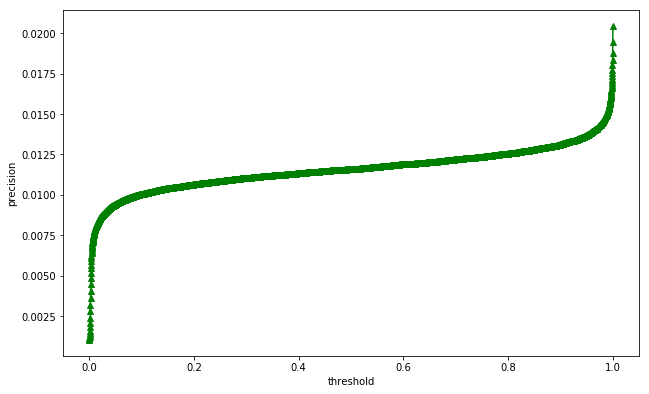

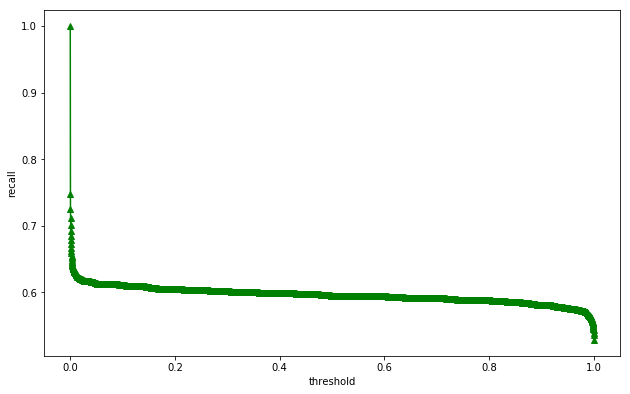

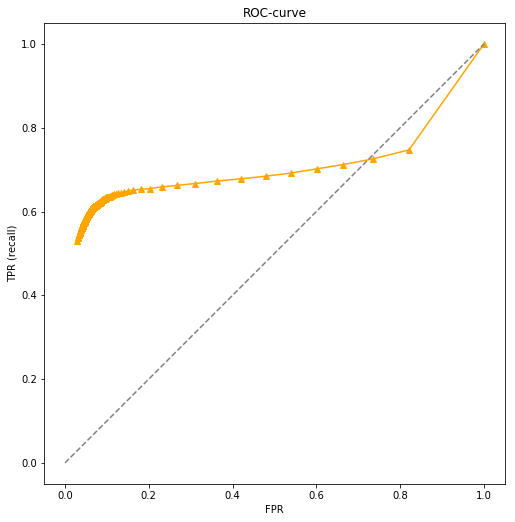

TP2 =  0.000671 %
FP2 =  0.057215 %
FN2 =  0.000456 %
TN2 =  0.941658 %


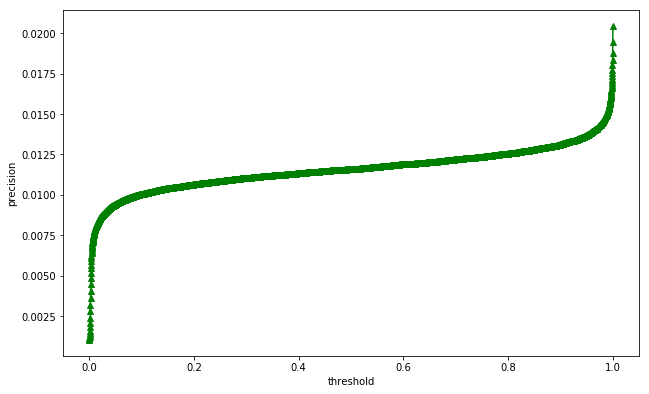

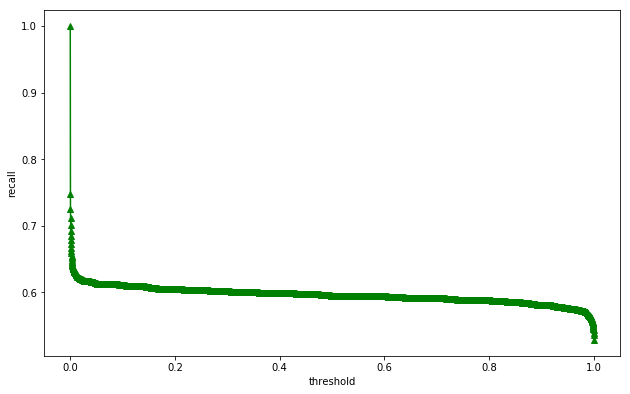

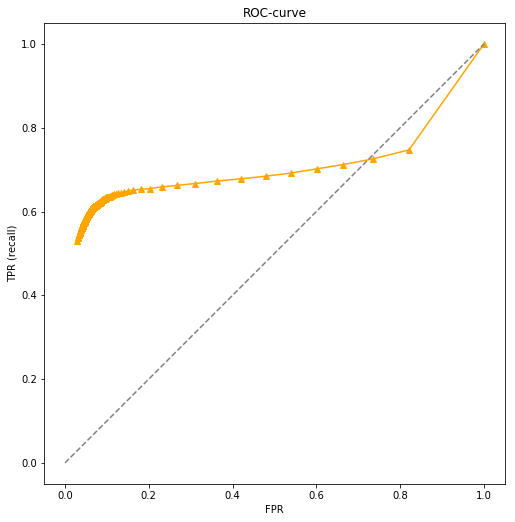

In [34]:
if (SAVE_INFO == True):
    INFO_FILE = open (EXPERIMENT_DIR + 'INFO.txt', 'w')
    
if (SAVE_INFO == True):
    print_INFO_to_file()
    
print_ROC_info (earthquake_network,
               earthquakes_dataloader_test,
               DEVICE,
               ) 

print_ROC_info2 (earthquake_network,
               earthquakes_dataloader_test,
               DEVICE,
               ) 

if (SAVE_INFO == True):
    INFO_FILE.close()

In [35]:
# OBSERVED_DAYS = 32     # 1 months
# DAYS_TO_PREDICT = 4
# STEP = 10

# train_data   = torch.zeros ([0, OBSERVED_DAYS, N_CELLS_HOR, N_CELLS_VER])
# train_result = torch.zeros ([0,             1, N_CELLS_HOR, N_CELLS_VER])
# for i in tqdm(range (OBSERVED_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT, STEP)):
#     current_history = torch.zeros ([0, N_CELLS_HOR, N_CELLS_VER])
#     for rest in range (OBSERVED_DAYS):   
#         current_history = torch.cat((current_history, celled_data[i - rest - 1, :, :, :]), dim=0)
#     current_history.unsqueeze(0)
#     train_data = torch.cat((train_data, current_history), dim=0)
    
# train_data   = torch.zeros ([0, OBSERVED_DAYS, N_CELLS_HOR, N_CELLS_VER])
# train_result = torch.zeros ([0,             1, N_CELLS_HOR, N_CELLS_VER])
# for i in tqdm(range (OBSERVED_DAYS, celled_data.shape[0] - DAYS_TO_PREDICT, STEP)):
#     current_history = torch.zeros ([0, N_CELLS_HOR, N_CELLS_VER])
#     for rest in range (OBSERVED_DAYS):
#         current_history = torch.cat((current_history, celled_data[i - rest, :, :, :]), dim=0)
#     current_history = current_history.unsqueeze(0)
#     train_data = torch.cat((train_data, current_history), dim=0)

#     train_result = torch.cat ((train_result, torch.sum (celled_data[i:(i + DAYS_TO_PREDICT), :, :, :], dim=0, keepdim=True)), dim=0)

#     print ('train_data', train_data.shape)
#     print ('train_result       ', train_result.shape)
    

In [36]:
# print (train_data.shape)
# print (train_result.shape)

In [37]:
# class ConvNetwork_MSE (nn.Module):
    
#     def __init__(self):
#         super(ConvNetwork_CE, self).__init__()
        
#         self.features = nn.Sequential()
        
#         self.features.add_module('conv1', ConvBlock(     OBSERVED_DAYS    , int (OBSERVED_DAYS/2 ), 3))
#         self.features.add_module('conv2', ConvBlock(int (OBSERVED_DAYS/2 ), int (OBSERVED_DAYS/4 ), 3))
#         self.features.add_module('conv3', ConvBlock(int (OBSERVED_DAYS/4 ), int (OBSERVED_DAYS/8 ), 3))
#         self.features.add_module('conv4', ConvBlock(int (OBSERVED_DAYS/8 ), int (OBSERVED_DAYS/16), 3))
#         self.features.add_module('conv5', ConvBlock(int (OBSERVED_DAYS/16),                      1, 3))
        
#         # might be a good idea to add an extra full connected layer
        
#     def forward(self, x):
# #         print ('input  : ', x.shape)
#         x = self.features(x)
# #         print ('output : ', x.shape)
#         return x
        

In [38]:
# def train_network_MSE(network, 
#                       device,
#                       dataloader_train,
#                       dataloader_test,
#                       epochs=164,
#                       learning_rate=0.1):
    
#     train_acc = []
#     test_acc  = []
#     net = network.to(device)

#     criterion = nn.MSELoss()
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)

    
#     for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
#         if epoch == epochs/2:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/10, weight_decay=0.0001, momentum=0.9) 
#         elif epoch == epochs*3/4:
#             optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate/100, weight_decay=0.0001, momentum=0.9) 
        
#         net = net.train()        
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_train:
            
#             inputs = data[0].to(device)
#             labels = data[1].to(device)
# #             print ('inputs_shape = ', inputs.shape)
# #             print ('labels_shape = ', labels.shape)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
# #             print ('outputs : ', outputs.dtype)
# #             print ('labels  : ', labels.dtype)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

# #             print (loss)
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         train_acc.append(epoch_accuracy)
        
        
#         # calculating test accuracy
#         epoch_accuracy = 0.0
#         epoch_elems = 0
#         for data in dataloader_test:
#             inputs = data[0].to(device)
#             labels = data[1].to(device)   
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
            
#             epoch_elems    += labels.shape[0]
#             epoch_accuracy += loss.item()*labels.shape[0]

#         epoch_accuracy /= epoch_elems
#         test_acc.append(epoch_accuracy)
        
        
#         print('Epoch : ', epoch, 'acc_train : ', round (train_acc[-1], 4), 'acc_test : ', round (test_acc[-1], 4))

#     print('Finished Training')
    
#     plt.plot(train_acc, label='Train')
#     plt.plot(test_acc , label='Test' )
#     plt.legend()
#     plt.grid()

In [39]:
# earthquake_netowrk = ConvNetwork_MSE ()
# train_network_MSE (earthquake_netowrk,
#                    torch.device(DEVICE),
#                    earthquakes_dataloader_train,
#                    earthquakes_dataloader_test,
#                    epochs=200,
#                    )

In [40]:
# def find_mistake (x):
#     assert (torch.sum((x < 0.0) + (x > 1.0)) == 0)

In [41]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print ('input  : ', input.shape, input.dtype)
# print (input)
# print (torch.sum (input, dim = 0))
# print ('target : ', target.shape, target.dtype)
# print (target)
# output = loss(input, target)
# output.backward()

In [42]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class someDataset (Dataset):
#     def __init__(self):
#         self.data = torch.ones ([100, 32, 10, 10])
#         self.labels = torch.ones ([100, 1, 10, 10])
#         self.len  = self.data.shape[0]
        
#         print (self.data.shape)
#         print (self.labels.shape)
        
#     def __len__ (self):
#         return self.len
    
#     def __getitem__(self, idx):
#         print ('data_shape = ', self.data[idx].shape)
#         print ('result_shape = ', self.labels[idx].shape)
#         return self.data[idx], self.labels[idx]

In [43]:
# some_dataset = someDataset()
# dataloader = DataLoader (some_dataset,
#                          batch_size=32,
#                          shuffle=True,
#                          num_workers=1,
#                          )

# for i, batch in enumerate(dataloader, 0):
#     data = batch[0]
#     print (i, 'data ', data.shape)e84508f39835db0e3fe66610d290a9aee30df73e15fca359
#     labels = batch[1]
#     print (i, 'labels ', labels.shape)
    


# # eartquakes_dataloader_train = DataLoader(earthquakes_dataset_train,
# #                                          batch_size=33,
# #                                          shuffle=True,
# #                                          num_workers=4)
